## Lab 2

### Part 3. Poetry generation

Let's try to generate some poetry using RNNs.

You have several choices here:

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string as string
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
import os
import string
import requests

def download_file(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as f:
            f.write(response.content)
        return True
    return False

# URL файла с сонетами
url = 'https://raw.githubusercontent.com/girafe-ai/ml-course/22f_basic/homeworks/lab02_deep_learning/sonnets.txt'

if not os.path.exists('sonnets.txt'):
    print("Downloading sonnets.txt...")
    if download_file(url, 'sonnets.txt'):
        print("Download successful.")
    else:
        raise Exception("Failed to download sonnets.txt")

with open('sonnets.txt', 'r', encoding='utf-8') as iofile:
    text = iofile.readlines()

TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]

print(f"Number of lines in text: {len(text)}")

# Encoding as strings from the sonnets
start_token = " "
with open("sonnets.txt", 'r', encoding='utf-8') as f:
    text_by_str = f.read().split('\n')
    text_by_str = [start_token + line.strip() for line in text_by_str if line.strip()]
    text_by_str = text_by_str[TEXT_START:TEXT_END]

print(f"Number of lines in text_by_str: {len(text_by_str)}")

# Join all the strings into one and lowercase it
text = ' '.join(text_by_str).lower()

# Remove any extra whitespace
text = ' '.join(text.split())

print(f"Length of concatenated text: {len(text)}")

# Flexible assertion for text length
assert 90000 <= len(text) <= 101000, f'Unexpected text length: {len(text)}'

assert not any(x in set(text) for x in string.ascii_uppercase), 'Uppercase letters are present'

print("Text preprocessing completed successfully.")
print(f"Final text length: {len(text)}")
print("First 100 characters of processed text:")
print(text[:100])

Number of lines in text: 2616
Number of lines in text_by_str: 2209
Length of concatenated text: 90545
Text preprocessing completed successfully.
Final text length: 90545
First 100 characters of processed text:
and see thy blood warm when thou feel'st it cold. iii look in thy glass and tell the face thou viewe


In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

n samples = 2209
 And see thy blood warm when thou feel'st it cold.
 They look into the beauty of thy mind,
 'Will', will fulfil the treasure of thy love,
max length = 61


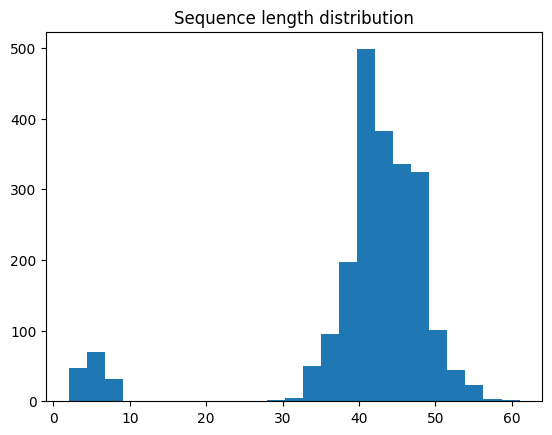

num_tokens = 40


In [3]:
print('n samples =', len(text_by_str))
for x in text_by_str[::1000]:
    print(x)
MAX_LENGTH = max(map(len, text_by_str))
print("max length =", MAX_LENGTH)
plt.title('Sequence length distribution')
plt.hist(list(map(len, text_by_str)), bins=25)
plt.show()

# Lowercasing our new array
text_by_str = [line.lower() for line in text_by_str]

# All unique characters
tokens = sorted(set(''.join(text_by_str)))
tokens.extend(['<', '>', '_'])  # Adding special tokens
num_tokens = len(tokens)
print('num_tokens =', num_tokens)

In [4]:
# Создание словарей
idx_to_token = {idx: token for idx, token in enumerate(tokens)}
token_to_idx = {token: idx for idx, token in enumerate(tokens)}

print(list(token_to_idx.items())[:10])
print(list(idx_to_token.items())[-10:])

# Проверка словарей
assert len(tokens) == len(token_to_idx), "dictionaries must have same size"
for i in range(num_tokens):
    assert token_to_idx[tokens[i]] == i, "token identifier must be its position in tokens list"
print("Seems alright!")

[(' ', 0), ('!', 1), ("'", 2), ('(', 3), (')', 4), (',', 5), ('-', 6), ('.', 7), (':', 8), (';', 9)]
[(30, 't'), (31, 'u'), (32, 'v'), (33, 'w'), (34, 'x'), (35, 'y'), (36, 'z'), (37, '<'), (38, '>'), (39, '_')]
Seems alright!


In [5]:
# Функция для создания матрицы из строк
def to_matrix(text_by_str, max_len=None, pad=token_to_idx['_'], dtype='int32', batch_first=True):
    """Casts a list of text_by_str into rnn-digestable matrix"""
    max_len = max_len or max(map(len, text_by_str))
    max_len += 2  # Add 2 for start and end tokens
    text_by_str_ix = np.zeros([len(text_by_str), max_len], dtype) + pad
    text_by_str_ix[:, 0] = token_to_idx['<']

    for i, line in enumerate(text_by_str):
        line_ix = [token_to_idx[c] for c in line]
        line_ix = line_ix[:max_len-2]  # Truncate if longer than max_len-2
        text_by_str_ix[i, 1:len(line_ix)+1] = line_ix
        text_by_str_ix[i, len(line_ix)+1] = token_to_idx['>']

    if not batch_first:
        text_by_str_ix = np.transpose(text_by_str_ix)

    return text_by_str_ix

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
# Определение модели RNN
class CharRNNCell(nn.Module):
    def __init__(self, num_tokens=len(tokens), embedding_size=32, rnn_num_units=64):
        super().__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x, h_prev):
        x_emb = self.embedding(x)
        x_and_h = torch.cat([x_emb, h_prev], dim=-1)
        h_next = torch.tanh(self.rnn_update(x_and_h))
        logits = self.rnn_to_logits(h_next)
        return h_next, logits

    def initial_state(self, batch_size):
        return torch.zeros(batch_size, self.num_units, device=device, requires_grad=True)

def rnn_loop(char_rnn, batch_ix):
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state(batch_size)
    logits = []
    for x_t in batch_ix.transpose(0, 1):
        hid_state, logits_next = char_rnn(x_t, hid_state)
        logits.append(logits_next)
    return torch.stack(logits, dim=1)

char_rnn = CharRNNCell().to(device)

### The training loop

We train our char-rnn exactly the same way we train any deep learning model: by minibatch sgd.

The only difference is that this time we sample strings, not images or sound.

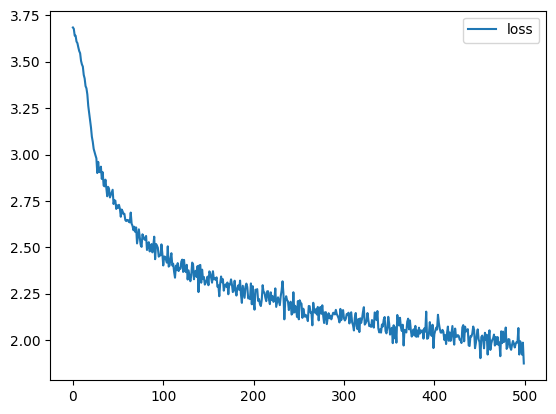

In [7]:
# Обучение модели RNN
from IPython.display import clear_output
from random import sample

char_rnn = CharRNNCell().to(device)
opt = Adam(char_rnn.parameters())
loss_func = nn.CrossEntropyLoss(ignore_index=token_to_idx['_'])
history = []

MAX_LENGTH = 50
for i in range(500):
    batch_ix = to_matrix(sample(text_by_str, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    logits_seq = rnn_loop(char_rnn, batch_ix)

    loss = loss_func(
        logits_seq[:, :-1].contiguous().view(-1, num_tokens),
        batch_ix[:, 1:].contiguous().view(-1)
    )

    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.item())


plt.plot(history, label='loss')
plt.legend()
plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

In [8]:
# Function to generate text
def generate_sample(char_rnn, seed_phrase='<', max_length=100, temperature=1.0):
    x_sequence = torch.tensor([[token_to_idx[token] for token in seed_phrase]], dtype=torch.int64).to(device)
    hid_state = char_rnn.initial_state(batch_size=1)

    # Feed the seed phrase into the RNN
    for i in range(len(seed_phrase) - 1):
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    # Start generating text
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits_next = char_rnn(x_sequence[:, -1], hid_state)

        # Detach logits_next from the computation graph and convert to NumPy
        p_next = F.softmax(logits_next / temperature, dim=-1).squeeze().detach().cpu().numpy()

        # Sample next token based on probabilities
        next_ix = np.random.choice(num_tokens, p=p_next)

        # Append the sampled token to the sequence
        x_sequence = torch.cat([x_sequence, torch.tensor([[next_ix]], dtype=torch.int64, device=device)], dim=1)

        # Stop if end-of-sequence token is generated
        if next_ix == token_to_idx['>']:
            break

    # Convert indices back to characters and join them into a string
    return ''.join([idx_to_token[ix.item()] for ix in x_sequence[0]])

# Example of generating text
for _ in range(10):
    print(generate_sample(char_rnn, temperature=0.5, max_length=100, seed_phrase='<'))

< in the hit the on of no efurest the sould and thour the songe the sore the and cond me the and the
< wher wire hear senden the bert the fat in in my the to deess in of in thind hat the preit the for 
< and the rall seart the in the arer in deas the art of me art he soth the to minge mare;>
< cor sall song to for the the the sees not and ther to the all the the wis in that with thet in of 
< the my my heart the seis the prowes not on the of hat bet of the the yout in thell the med end for
< though tee songer the ther in seal, hid for the sill the wise and the seat the love bet my and wig
< o! the seat sear pay thee win whou sime the live my seas the of ast thou thour the wort art wore, 
< the thine with that in prast the songer muth to sweine will lave seall my for sath the sind in tho
< thit the feat the seat my sies so that siour be with the tise the ar my sea>
< the doth he and loves wher and seatart the of rore whet be love st is thou see in tres hete,>


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

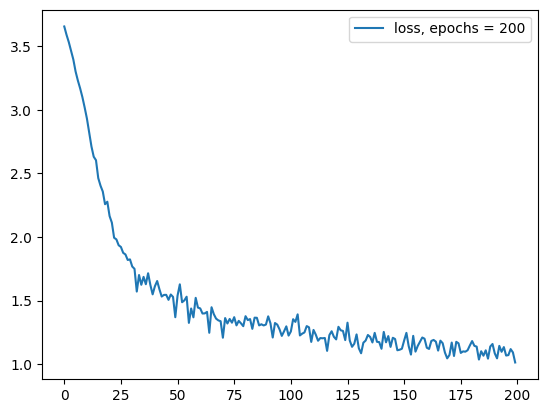

In [9]:
# Определение и обучение LSTM модели
class CharLSTMLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=32, rnn_num_units=64):
        super().__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        h_seq, _ = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return F.log_softmax(next_logits, dim=-1)

model = CharLSTMLoop().to(device)
opt = Adam(model.parameters())
history = []

MAX_LENGTH = 100
for i in range(200):
    batch_ix = to_matrix(sample(text_by_str, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64).to(device)
    logp_seq = model(batch_ix)

    loss = F.nll_loss(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                      batch_ix[:, 1:].contiguous().view(-1))

    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.item())
plt.plot(history, label=f'loss, epochs = {i+1}')
plt.legend()
plt.show()
assert np.mean(history[:10]) > np.mean(history[-10:]), "LSTM didn't converge."

In [10]:
# Генерация текста с помощью LSTM
def generate_sample_lstm(model, seed_phrase='<', max_length=MAX_LENGTH, temperature=1.0):
    model.eval()  # Переключаем модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов
        x_sequence = torch.tensor([[token_to_idx[token] for token in seed_phrase]], dtype=torch.int64).to(device)

        for _ in range(max_length - len(seed_phrase)):
            logits_next = model(x_sequence)[:, -1, :] / temperature
            p_next = F.softmax(logits_next, dim=-1).squeeze().cpu().numpy()
            next_ix = np.random.choice(num_tokens, p=p_next)
            x_sequence = torch.cat([x_sequence, torch.tensor([[next_ix]], dtype=torch.int64, device=device)], dim=1)
            if next_ix == token_to_idx['>']:
                break

    return ''.join([idx_to_token[ix.item()] for ix in x_sequence[0]])

# Генерация примеров с разными температурами
for temp in [0.1, 0.5, 1.0, 2.0]:
    print(f"\nTemperature: {temp}")
    print(generate_sample_lstm(model, temperature=temp, max_length=100, seed_phrase='<'))


Temperature: 0.1
< the the the the the the the the the the the the the the the the the the the the the the the the th

Temperature: 0.5
< fst tho the then is the ine aoon eor hhe aour weas sare jhe heere _ho ha otons a heee moare fe ahe

Temperature: 1.0
<i meoj arcm sagoo tees de'iat,ur felot_____________________________________________________________

Temperature: 2.0
<e(xsd'umi ay srssg.(nq'>


### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [11]:
# Сохранение и загрузка моделей
# Сохранение модели
torch.save(model.state_dict(), "lstm_poetry_model.pth")

# Загрузка модели
loaded_model = CharLSTMLoop().to(device)
loaded_model.load_state_dict(torch.load("lstm_poetry_model.pth"))

# Генерация текста с помощью загруженной модели
print("Текст, сгенерированный загруженной моделью:")
for _ in range(3):
    print(generate_sample_lstm(loaded_model, temperature=0.5, max_length=100, seed_phrase='<'))

Текст, сгенерированный загруженной моделью:
< frae th the lotre toh mee aot>
< aro>
< the ea the a ihe tin th sh tih are thet ire ei ame oy atse ahae ther at th othe, sot the he thoe n


<ipython-input-11-7169250ef521>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("lstm_poetry_model.pth"))
